In [1]:
# Import required libraries
import pandas as pd
import numpy as np

# Load all cleaned datasets
claims = pd.read_csv('Dataset_Cleaned/Cleaned_Train_Claims.csv')
beneficiary = pd.read_csv('Dataset_Cleaned/Cleaned_Train_Beneficiary.csv')
inpatient = pd.read_csv('Dataset_Cleaned/Cleaned_Train_Inpatient.csv')
outpatient = pd.read_csv('Dataset_Cleaned/Cleaned_Train_Outpatient.csv')

# Combine inpatient and outpatient into a single claim-level dataset
all_claims = pd.concat([inpatient, outpatient], axis=0)

In [2]:
claims_features = all_claims.groupby('Provider').agg(
    total_claims=('ClaimID', 'count'),
    avg_reimbursement=('InscClaimAmtReimbursed', 'mean'),
    max_reimbursement=('InscClaimAmtReimbursed', 'max'),
    total_reimbursement=('InscClaimAmtReimbursed', 'sum'),
    avg_deductible=('DeductibleAmtPaid', 'mean')
).reset_index()

In [3]:
# Convert dates to datetime
inpatient['ClaimStartDt'] = pd.to_datetime(inpatient['ClaimStartDt'], errors='coerce')
inpatient['ClaimEndDt'] = pd.to_datetime(inpatient['ClaimEndDt'], errors='coerce')

# Compute stay length
inpatient['LengthOfStay'] = (inpatient['ClaimEndDt'] - inpatient['ClaimStartDt']).dt.days
inpatient = inpatient[inpatient['LengthOfStay'] >= 0]  # Remove invalid stays

inpatient_los = inpatient.groupby('Provider')['LengthOfStay'].mean().reset_index()
inpatient_los.rename(columns={'LengthOfStay': 'avg_length_of_stay'}, inplace=True)

In [4]:
# Join all claims with beneficiary data
claims_with_bene = all_claims.merge(beneficiary, on='BeneID', how='left')

# Count of chronic conditions per patient
chronic_cols = [col for col in beneficiary.columns if col.startswith('ChronicCond_')]
claims_with_bene['num_chronics'] = claims_with_bene[chronic_cols].replace({2: 0}).sum(axis=1)

# Group features at provider level
bene_features = claims_with_bene.groupby('Provider').agg(
    avg_patient_chronics=('num_chronics', 'mean'),
    avg_months_partA=('NoOfMonths_PartACov', 'mean'),
    avg_months_partB=('NoOfMonths_PartBCov', 'mean'),
    percent_renal_disease=('RenalDiseaseIndicator', lambda x: (x == 'Y').mean()),
    gender_ratio=('Gender', lambda x: (x == 1).mean())  # Proportion male
).reset_index()

In [5]:
# Convert '2' (no) to 0 for aggregation
chronic_ratios = claims_with_bene.replace({2: 0})

# Compute average presence of each condition per provider
chronic_agg = chronic_ratios.groupby('Provider')[chronic_cols].mean().reset_index()
chronic_agg.columns = ['Provider'] + [f'{col}_ratio' for col in chronic_cols]

In [7]:
# Combine all feature sets
features_df = claims_features \
    .merge(inpatient_los, on='Provider', how='left') \
    .merge(bene_features, on='Provider', how='left') \
    .merge(chronic_agg, on='Provider', how='left') \
    .merge(claims, on='Provider', how='left')  # to get PotentialFraud label

# Save to file
features_df.to_csv('Dataset_Cleaned/provider_features.csv', index=False)

In [21]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the feature dataset
features = pd.read_csv('Dataset_Cleaned/provider_features.csv')

# Drop non-feature columns
X = features.drop(columns=['Provider', 'PotentialFraud'])
X = X.fillna(X.median())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Encode fraud labels (Yes = 1, No = 0)
y = features['PotentialFraud'].map({'No': 0, 'Yes': 1})

# Train-test split (stratify to handle class imbalance)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score

xgb_model = XGBClassifier(scale_pos_weight=(y == 0).sum() / (y == 1).sum(), eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Define baseline models
models = {
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=2000, class_weight='balanced'),
    'XGBoost': xgb_model
}

# Evaluate each model
for name, model in models.items():
    print(f'{name} Results:')
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print('ROC AUC Score:', roc_auc_score(y_test, preds))
    print(classification_report(y_test, preds))
    print('-' * 50)

Random Forest Results:
ROC AUC Score: 0.7339096294950596
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       981
           1       0.74      0.49      0.59       101

    accuracy                           0.94      1082
   macro avg       0.85      0.73      0.78      1082
weighted avg       0.93      0.94      0.93      1082

--------------------------------------------------
Logistic Regression Results:
ROC AUC Score: 0.8797953189814394
              precision    recall  f1-score   support

           0       0.99      0.87      0.92       981
           1       0.41      0.89      0.56       101

    accuracy                           0.87      1082
   macro avg       0.70      0.88      0.74      1082
weighted avg       0.93      0.87      0.89      1082

--------------------------------------------------
XGBoost Results:
ROC AUC Score: 0.7930228802696784
              precision    recall  f1-score   support

           0      

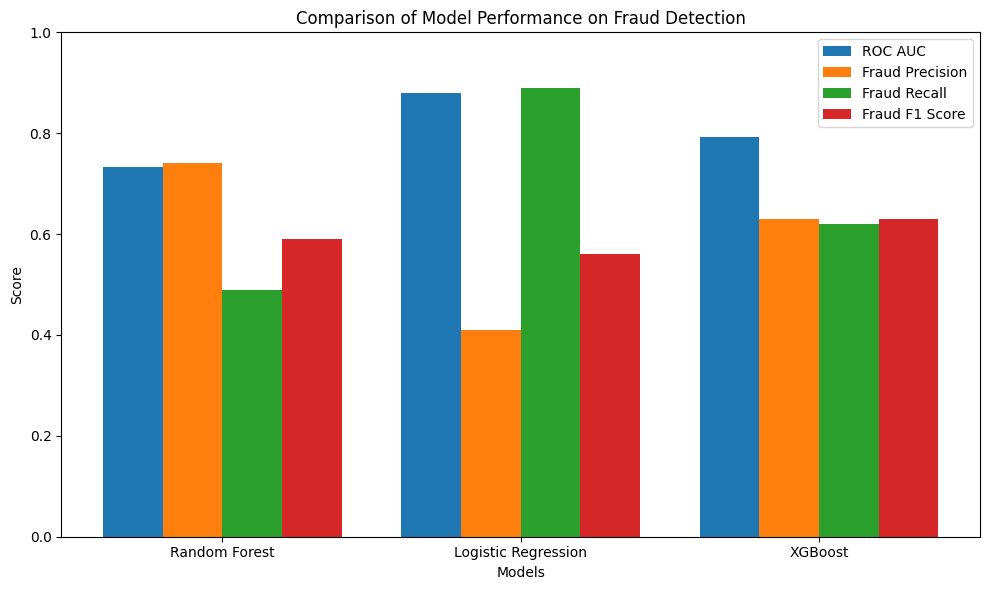

In [34]:
import matplotlib.pyplot as plt

# Model names
models = ['Random Forest', 'Logistic Regression', 'XGBoost']

# Corresponding metric values from evaluation
roc_auc = [0.7339, 0.8798, 0.7930]
precision = [0.74, 0.41, 0.63]
recall = [0.49, 0.89, 0.62]
f1 = [0.59, 0.56, 0.63]

# Bar chart configuration
bar_width = 0.2
index = range(len(models))

# Create figure
plt.figure(figsize=(10, 6))

# Plot each metric
plt.bar(index, roc_auc, bar_width, label='ROC AUC')
plt.bar([i + bar_width for i in index], precision, bar_width, label='Fraud Precision')
plt.bar([i + bar_width*2 for i in index], recall, bar_width, label='Fraud Recall')
plt.bar([i + bar_width*3 for i in index], f1, bar_width, label='Fraud F1 Score')

# Add labels and styling
plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Comparison of Model Performance on Fraud Detection')
plt.xticks([i + 1.5 * bar_width for i in index], models)
plt.ylim(0, 1)
plt.legend()

# Save and show plot
plt.tight_layout()
plt.savefig('Visualization_Images/model_comparison_plot.png')  # Saves to your current folder
plt.show()

In [31]:
import shap

# Create SHAP explainer using the final XGBoost model
explainer = shap.Explainer(xgb_model, X_test)

# Get SHAP values for the test set
shap_values = explainer(X_test)

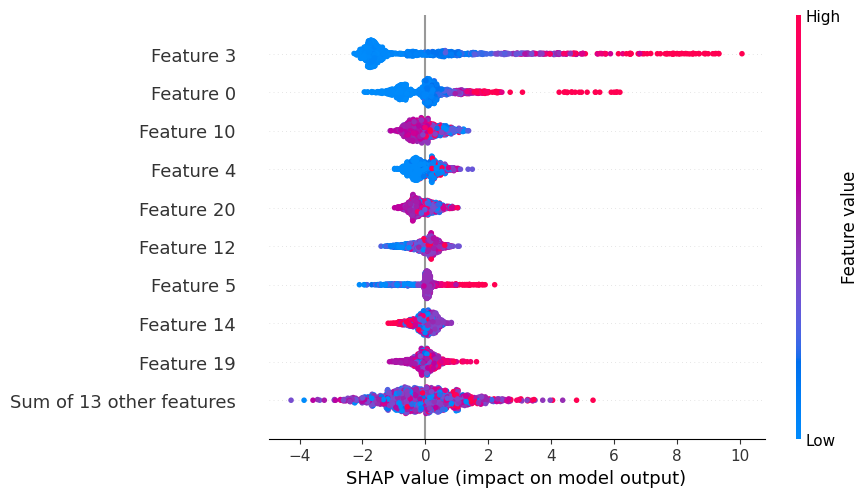

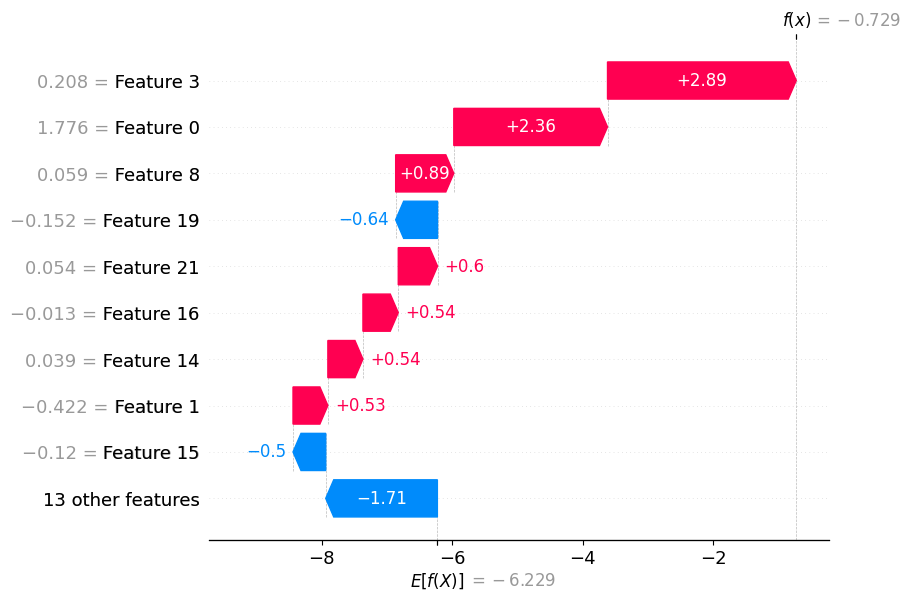

In [37]:
# Plot feature importance (Beeswarm plot)
shap.plots.beeswarm(shap_values)

# Plot the contribution of features for a specific instance (Waterfall plot)
shap.plots.waterfall(shap_values[0])  # First prediction